# Home 4: Build a CNN for image recognition.

### Name: Asif Uddin


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [38]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [5]:
def to_one_hot(y, num_class=10):
    b = numpy.zeros((y.size,num_class))
    b[numpy.arange(y.size),y.reshape(y.size)] = 1
    return b

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [6]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [42]:
from keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from keras.models import Sequential, Model
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_58 (Batc (None, 16, 16, 64)       

In [44]:
from keras import optimizers

learning_rate = 1E-3 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [45]:
# Data Augmentation
bs = 64
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
it_train = datagen.flow(x_tr, y_tr, batch_size=bs)
steps = int(x_tr.shape[0] / bs)
history = model.fit(it_train, steps_per_epoch=steps, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
625/625 [==============================] - 26s 40ms/step - loss: 1.9286 - acc: 0.3255 - val_loss: 1.6037 - val_acc: 0.4488
Epoch 2/25
625/625 [==============================] - 24s 39ms/step - loss: 1.4216 - acc: 0.4861 - val_loss: 1.2320 - val_acc: 0.5606
Epoch 3/25
625/625 [==============================] - 24s 39ms/step - loss: 1.2383 - acc: 0.5545 - val_loss: 1.1430 - val_acc: 0.6076
Epoch 4/25
625/625 [==============================] - 24s 38ms/step - loss: 1.1481 - acc: 0.5936 - val_loss: 1.1140 - val_acc: 0.6270
Epoch 5/25
625/625 [==============================] - 24s 38ms/step - loss: 1.0650 - acc: 0.6191 - val_loss: 0.9612 - val_acc: 0.6584
Epoch 6/25
625/625 [==============================] - 24s 39ms/step - loss: 0.9996 - acc: 0.6482 - val_loss: 0.9924 - val_acc: 0.6746
Epoch 7/25
625/625 [==============================] - 24s 39ms/step - loss: 0.9585 - acc: 0.6629 - val_loss: 0.9130 - val_acc: 0.6921
Epoch 8/25
625/625 [==============================] - 24s 39ms

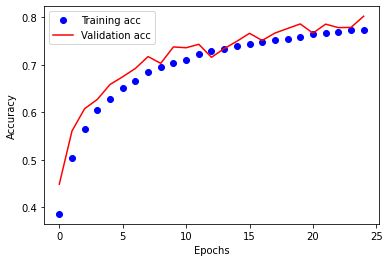

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [47]:
# <Compile your model again (using the same hyper-parameters)>
# ...
from keras import optimizers

learning_rate = 1E-3 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [48]:
# <Train your model on the entire training set (50K samples)>
# <Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
# <Do NOT use the validation_data option (because now you do
# ...
bs = 64
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
it_train = datagen.flow(x_train, y_train_vec, batch_size=bs)
history = model.fit(it_train, steps_per_epoch=x_train.shape[0]/bs, epochs=25)

Epoch 1/25
781/781 [==============================] - 30s 37ms/step - loss: 0.6651 - acc: 0.7694
Epoch 2/25
781/781 [==============================] - 29s 37ms/step - loss: 0.6484 - acc: 0.7753
Epoch 3/25
781/781 [==============================] - 28s 36ms/step - loss: 0.6456 - acc: 0.7777
Epoch 4/25
781/781 [==============================] - 29s 37ms/step - loss: 0.6298 - acc: 0.7853
Epoch 5/25
781/781 [==============================] - 29s 37ms/step - loss: 0.6356 - acc: 0.7815
Epoch 6/25
781/781 [==============================] - 28s 36ms/step - loss: 0.6232 - acc: 0.7834
Epoch 7/25
781/781 [==============================] - 29s 37ms/step - loss: 0.6070 - acc: 0.7882
Epoch 8/25
781/781 [==============================] - 29s 37ms/step - loss: 0.5920 - acc: 0.7972
Epoch 9/25
781/781 [==============================] - 29s 37ms/step - loss: 0.5959 - acc: 0.7944
Epoch 10/25
781/781 [==============================] - 29s 37ms/step - loss: 0.5891 - acc: 0.7930
Epoch 11/25
781/781 [========

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [49]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.5443 - acc: 0.8193
loss = 0.5443256497383118
accuracy = 0.8192999958992004
